# Mixed-radix FFT

This notebook  presents the use of a hardware overlay for mixed-radix FFT for input size = 8000 
Hardware performs 


In [1]:
from pynq import (allocate, Overlay)
from sys import maxsize
import numpy as np
import math
from math import log
#from scipy import fft
from numpy.fft import fft
import time
#from scipy import signal

## Load the overlay

Program the FPGA and reference the required hardware blocks.

In [3]:
#ol = Overlay('mr8k_cu3.bit')
#ol = Overlay('mr8k-cu3-updated.bit')
#ol = Overlay('mr8k_cu2.bit')
#ol = Overlay('cu5-hce.bit')
#ol = Overlay('24fast.bit')
#ol = Overlay('cu5.bit')
#ol = Overlay('64cu5_125cu1df.bit')
#ol = Overlay('64cu5_125cu2.bit')
#ol = Overlay('24onhost.bit')
#ol = Overlay('cu5_cu4.bit')
#ol = Overlay('ap-24-dp.bit')
#ol = Overlay('ctfft64.bit')
ol = Overlay('ond8000.bit')
#ol = Overlay('1600_ap_fixed.bit')
#ol = Overlay('ctap.bit')
#ol = Overlay('ctst.bit')
#ol = Overlay('24-8.bit')
#ol = Overlay('../fftip.bit')
#ol = Overlay('lb.bit')
#ol = Overlay('mr8k-cu2-hardcoded.bit')
dma = ol.dma
mmult_ip = ol.matmult_accel_0

## Allocate memory for the DMA transfers

In [4]:
DIM = 8000
in_buffer = allocate(shape=(2*DIM), dtype=np.float32, cacheable=False)
out_buffer = allocate(shape=(2*DIM), dtype=np.float32, cacheable=False)


## MR-FFT in hardware (PL side)

The execution of the algorithm using the hardware kernel includes the roundtrip data transfer (processor to FPGA, and FPGA to processor). 

In [5]:
CTRL_REG = 0x00
AP_START = (1<<0) # bit 0
AUTO_RESTART = (1<<7) # bit 7
mmult_ip.register_map.k = DIM
mmult_ip.register_map.m = DIM
mmult_ip.register_map.n = DIM

def run_kernel():
    #dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    mmult_ip.write(CTRL_REG, (AP_START | AUTO_RESTART))  # initialize the module
    #dma.sendchannel.wait()
    dma.recvchannel.wait()

Create example input to evaluate the kernel.

In [6]:
# Configure Numpy to avoid summarizing large arrays when printing their reprs.
#np.set_printoptions(threshold=maxsize, suppress=True, floatmode="unique")


def find_round_freqs(fft_size: int, f_sampling: int) -> np.ndarray:
    """Find FFT bins with round frequencies.

    Arguments
    ---------
    fft_size : int
        The size of the FFT to evaluate frequency bins for.
    f_sampling : int
        The sampling rate of the data the FFT would be applied to.

    Returns
    -------
    round_freqs : numpy.ndarray
        Frequency bins for the given FFT parameters where the frequencies are
        round.
    """

    # Calculate positive (right) frequencies for FFT bins.
    rfftfreqs = np.fft.rfftfreq(fft_size, d=f_sampling**-1)
    # Compare frequencies with their rounded counterpart and check that they
    # are equivalent to within machine epsilon.
    round_freq_idxs = np.abs(rfftfreqs - np.round(rfftfreqs)) <= np.finfo("f8").eps
    # Grab round frequencies ignoring 0 Hz.
    round_freqs = rfftfreqs[round_freq_idxs & (rfftfreqs != 0.0)]

    return round_freqs

## Find input frequencies

In [7]:
f_sampling = 8000
fft_sizes = [1600, 2048, 8000, 8192]

for fft_size in fft_sizes:
    round_freqs = find_round_freqs(fft_size, f_sampling)
    print(f"FFT Size: {fft_size} - Round Frequencies:\n{round_freqs}\n")

FFT Size: 1600 - Round Frequencies:
[    5.    10.    15.    20.    25.    30.    35.    40.    45.    50.
    55.    60.    65.    70.    75.    80.    85.    90.    95.   100.
   105.   110.   115.   120.   125.   130.   135.   140.   145.   150.
   155.   160.   165.   170.   175.   180.   185.   190.   195.   200.
   205.   210.   215.   220.   225.   230.   235.   240.   245.   250.
   255.   260.   265.   270.   275.   280.   285.   290.   295.   300.
   305.   310.   315.   320.   325.   330.   335.   340.   345.   350.
   355.   360.   365.   370.   375.   380.   385.   390.   395.   400.
   405.   410.   415.   420.   425.   430.   435.   440.   445.   450.
   455.   460.   465.   470.   475.   480.   485.   490.   495.   500.
   505.   510.   515.   520.   525.   530.   535.   540.   545.   550.
   555.   560.   565.   570.   575.   580.   585.   590.   595.   600.
   605.   610.   615.   620.   625.   630.   635.   640.   645.   650.
   655.   660.   665.   670.   675.   680

## Generate input

In [9]:
#A = np.random.rand(DIM, DIM).astype(dtype=np.float32)
A = np.ones((DIM),dtype=np.float32)
BB = np.zeros((8192),dtype=np.float32)
CC = np.hamming(DIM);
CC = CC/np.sum(CC)
sumin=0;
#B = np.random.rand(DIM, DIM).astype(dtype=np.float32)
#B = np.ones((DIM),dtype=np.float32)
for i in range (2*DIM):
#in_buffer[:] = np.stack((A, B))
    if (i<DIM):
        #in_buffer[i] = (math.sin(2*math.pi*i/DIM) + math.sin(2*math.pi*i*600/DIM) +  math.cos(2*math.pi*i*1000/DIM) +  math.cos(2*math.pi*i*3000/DIM))/#1000000
        in_buffer[i] = (math.sin(2*math.pi*i*100/DIM))/8000
        #in_buffer[i] = (math.sin(2*math.pi*i*1000/DIM)) + (math.sin(2*math.pi*i*2000/DIM)) + (math.sin(2*math.pi*i*3000/DIM)) 
        #in_buffer[i] = math.sin(2*math.pi*i/DIM) + math.sin(2*math.pi*i*600/DIM) +  math.cos(2*math.pi*i*1000/DIM) +  math.cos(2*math.pi*i*3000/DIM)
        #in_buffer[i]/=400000000
        #in_buffer[i] = math.sin(2*math.pi*i*700/DIM)/
        #in_buffer[i] = math.sin(2*math.pi*i*4000/DIM) 
        #in_buffer[i] *=np.float32(CC[i])
        A[i]=in_buffer[i]
        #sumin +=np.abs(in_buffer[i])
        BB[i]=in_buffer[i]
    else:
        in_buffer[i] = 0 ##imaginary
    #   in_buffer[i] = math.cos(2*math.pi*(i-DIM)/DIM)


## Normalize the input

## Plot input (first 1000 samples)

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 4]
#hw_fft_data = np.abs(np.array(fft.rxbuf))
#sw_fft_data = np.abs(np.array(np.fft.fftn(din)))

#b = scipy.decimate(A, int(len(a)/500)+1)
B = A[0:1000]; #plot first 4000 samples
f0, ax0 = plt.subplots()
#B = scipy.signal.decimate(A, int(len(A)/8000)+1)
#ax0.set_yscale('log')
ax0.plot(B)
#ax0.plot(A)
#ax0.locator_params(axis='x', nbins=1000)
#plt.xticks(np.arange(0, 100, step=1))
ax0.set_xlabel('Samples')
ax0.set_ylabel('Input Values');
#print('mean squared error for  real output: ' + str(err_squared.mean()))

Measure the execution time.

In [11]:
#%%timeit
start_time = time.time()
for i in range (15):
    run_kernel()
print((time.time() - start_time)/15)
print("Runtime seconds- average of 15 hardware mixed-radix FFT runs ")

0.001721779505411784
Runtime seconds- average of 15 hardware mixed-radix FFT runs 


In [12]:
#print(out_buffer[1000])

## Numpy FFT in software (PS side)

NumPy is the golden standard against with the hardware implementation is compared. 


In [13]:
#%timeit 
start_time2 = time.time()
for i in range (15):
    A_f=np.fft.fft(A)
print((time.time() - start_time2)/15)
print("Runtime seconds- average of 15 numpy FFT runs ")

0.0052684307098388675
Runtime seconds- average of 15 numpy FFT runs 


## Print outputs and plot MSE 

In [14]:
#(A_f[1000])

#np.array_equal(np.real(np.fft.rfft(A)), out_buffer)

In [15]:


out_buffer
#out_buffer.size
#out_buffer[0,1,2,3,4....7999] -> Real data
#out_buffer[8000,8001,8002,......15999] -> Imaginary data

PynqBuffer([  0.00000000e+00,   0.00000000e+00,  -2.38418579e-07, ...,
              2.38418579e-07,   7.15255737e-07,   1.19209290e-06], dtype=float32)

Mean absolute difference in real values: abs(FFT_hw.real(:) - FFT_sw.real(:)) : 6.22957944876e-07
Mean absolute difference in imaginary values: abs(FFT_hw.real(:) - FFT_sw.real(:)) 1.07839829478e-06


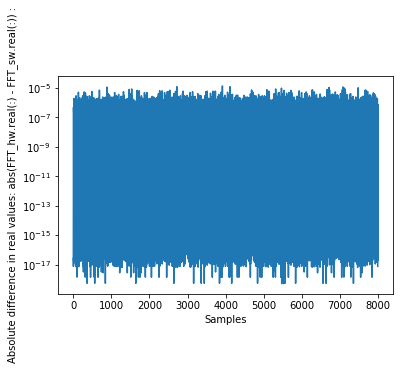

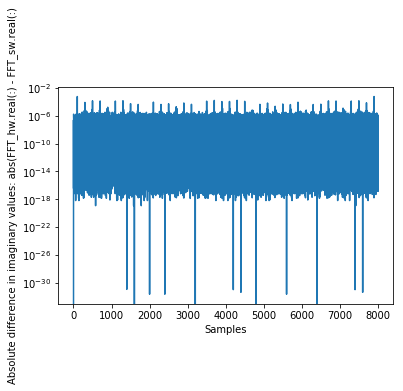

In [16]:
#import matplotlib.pyplot as plt
#hw_fft_data = np.abs(np.array(fft.rxbuf))
#sw_fft_data = np.abs(np.array(np.fft.fftn(din)))

hw_fft_rdata = np.zeros((DIM),dtype=np.float32)
hw_fft_idata = np.zeros((DIM),dtype=np.float32)
hw_fft_absdata = np.zeros((DIM),dtype=np.float32)
for i in range (DIM):
    hw_fft_rdata[i]=out_buffer[i]
    hw_fft_idata[i]=out_buffer[i+DIM]
    hw_fft_absdata[i]= math.sqrt(hw_fft_rdata[i]*hw_fft_rdata[i] + hw_fft_idata[i]*hw_fft_idata[i])


    
#f6, ax6 = plt.subplots()
#ax6.set_yscale('log')
#ax6.plot(hw_fft_absdata)
#ax6.set_xlabel('Samples')
#ax6.set_ylabel('Absolute value - HW Mixed-Radix 8K');  
    

    
sw_fft_rdata = np.real(A_f)
sw_fft_idata = np.imag(A_f)
sw_fft_absdata = np.abs(A_f)

#f5, ax5 = plt.subplots()
#ax5.set_yscale('log')
#ax5.plot(sw_fft_absdata)
#ax5.set_xlabel('Samples')
#ax5.set_ylabel('Absolute value - SW Numpy FFT 8K');


#err_squared = (hw_fft_rdata-sw_fft_rdata)**2
err_squared = abs(hw_fft_rdata-sw_fft_rdata)
f, ax = plt.subplots()
ax.plot(err_squared)
ax.set_yscale('log')
ax.set_xlabel('Samples')
ax.set_ylabel('Absolute difference in real values: abs(FFT_hw.real(:) - FFT_sw.real(:)) :');
print('Mean absolute difference in real values: abs(FFT_hw.real(:) - FFT_sw.real(:)) : ' + str(err_squared.mean()))

#err_squared2 = (hw_fft_idata-sw_fft_idata)**2
err_squared2 = abs(hw_fft_idata-sw_fft_idata)
f2, ax2 = plt.subplots()
ax2.set_yscale('log')
ax2.plot(err_squared2)
ax2.set_xlabel('Samples')
ax2.set_ylabel('Absolute difference in imaginary values: abs(FFT_hw.real(:) - FFT_sw.real(:)');
print('Mean absolute difference in imaginary values: abs(FFT_hw.real(:) - FFT_sw.real(:)) ' + str(err_squared2.mean()))

## Compute FFT 8192 and plot all outputs
### 1: MR-FFT-8000
### 2: Numpy-FFT-8000
### 3: Numpy-FFT-8192

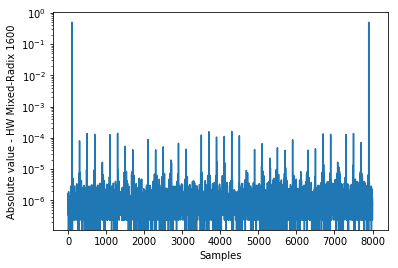

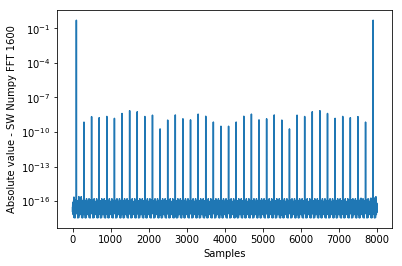

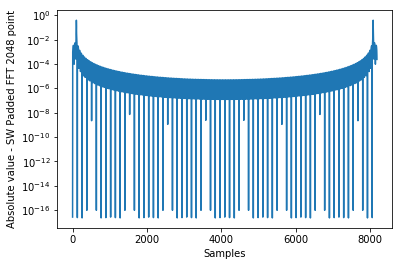

In [17]:
f6, ax6 = plt.subplots()
ax6.set_yscale('log')
ax6.plot(hw_fft_absdata)
ax6.set_xlabel('Samples')
ax6.set_ylabel('Absolute value - HW Mixed-Radix 1600');  
    

f5, ax5 = plt.subplots()
ax5.set_yscale('log')
ax5.plot(sw_fft_absdata)
ax5.set_xlabel('Samples')
ax5.set_ylabel('Absolute value - SW Numpy FFT 1600');


B_f =fft(BB)

sw_fft_r3data = np.real(B_f)
sw_fft_i3data = np.imag(B_f)
sw_fft_abs3data = np.abs(B_f)

f51, ax51 = plt.subplots()
ax51.set_yscale('log')
ax51.plot(sw_fft_abs3data)
ax51.set_xlabel('Samples')
ax51.set_ylabel('Absolute value - SW Padded FFT 2048 point');






# Print all elements with magnitude > 0.1

In [18]:
for i in range (hw_fft_absdata.size):
    if (hw_fft_absdata[i]>0.1):
        print("MR-FFT-1600-FPGA element ", i, "  magnitude " ,hw_fft_absdata[i])

MR-FFT-1600-FPGA element  100   magnitude  0.499436
MR-FFT-1600-FPGA element  7900   magnitude  0.499432


In [19]:
for i in range (sw_fft_absdata.size):
    if (sw_fft_absdata[i]>0.1):
        print("Numpy-FFT-1600 element ", i, "  magnitude " ,sw_fft_absdata[i])

Numpy-FFT-1600 element  100   magnitude  0.500000005477
Numpy-FFT-1600 element  7900   magnitude  0.500000005477


In [20]:
for i in range (sw_fft_abs3data.size):
    if (sw_fft_abs3data[i]>0.1):
        print("Numpy-FFT- element ", i, "  magnitude " ,sw_fft_abs3data[i])

Numpy-FFT-2048 element  101   magnitude  0.107154606888
Numpy-FFT-2048 element  102   magnitude  0.384368750007
Numpy-FFT-2048 element  103   magnitude  0.261022002726
Numpy-FFT-2048 element  8089   magnitude  0.261022002726
Numpy-FFT-2048 element  8090   magnitude  0.384368750007
Numpy-FFT-2048 element  8091   magnitude  0.107154606888
